<a href="https://colab.research.google.com/github/jopapo/instagram-post-crawler/blob/main/Colab_Instagram_Conti_Motocross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumo

Ferramenta de crawling de comentários do instagram (nesse caso dois post específicos) e busca de dados de quem comentou, o comentário e quando.

Depois faz uma análise de cada conjunto de dados de cada post pra extrair os resultados esperados.

## Limitações

Não considera imagens nem replys.

# 1. Preparação do ambiente

Instalação de ferramentas básicas para poder fazer o crawling no instagram.

In [1]:
!pip install selenium fuzzywuzzy pyquery
!apt-get update
!apt install chromium-chromedriver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.3/448.3 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,036 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jam

Configura um navegador pra rodar em background (Chrome) e simular um usuário

In [16]:
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--kiosk')
driver = webdriver.Chrome(chrome_options)

Dependências/bibliotecas necessárias à simulação

In [3]:
import sys, time, csv, pandas as pd

from getpass import getpass

from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

from IPython.display import Image, display, ProgressBar

from fuzzywuzzy import fuzz
from pyquery import PyQuery as pq



/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Função de apoio pra mostrar imagens do selenium.

In [4]:
global image_counter
image_counter = 0

def show_browser(element = None):
  global image_counter
  image_counter = image_counter + 1
  driver.save_screenshot(f'temp_{image_counter}.png')
  display(Image(f'temp_{image_counter}.png'))

  if element:
    with open(f'temp_{image_counter}.html', 'w') as f:
      f.write(driver.page_source if element == True else element.get_attribute('innerHtml'))

base_path = '/content/drive/MyDrive/temp'

# Autenticação no instagram

Primeira batida. Precisa logar pra ter o privilégio de navegar nos comentários... mesmo público.
(Aqui não tá 100% ainda, mas quebra um galo)

username:hurrah_
password:··········
Logado


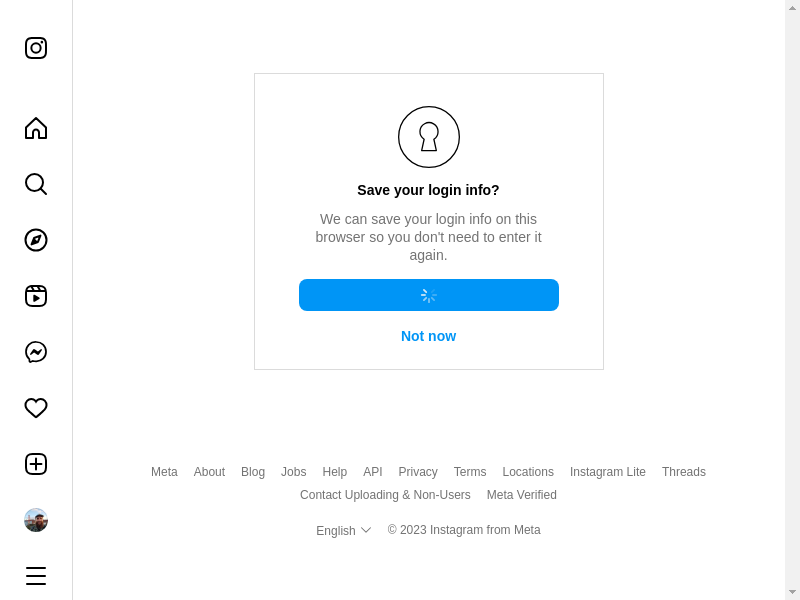

In [17]:
url="https://www.instagram.com/"

driver.get(url)
time.sleep(2)

try:
  username = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.NAME, "username"))
  )

  allow_cookies = driver.find_elements(By.XPATH, "//*[text()='Allow all cookies']")
  if len(allow_cookies):
    allow_cookies[0].click()

  username.send_keys(input('username:'))

  password = driver.find_element(By.NAME,"password")
  password.send_keys(getpass('password:'))

  password.submit()

  try:
    unusual_login = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[text()='Send Security Code']"))
    )
    show_browser()
    unusual_login.click() #SMS
  except TimeoutException:
    pass

  try:
    security_code_input = WebDriverWait(driver, 10).until(
        EC.any_of(
          EC.presence_of_element_located((By.ID, "security_code")),
          EC.presence_of_element_located((By.NAME, "verificationCode"))
        )
    )

    security_code_input.send_keys(getpass('security_code'))
    security_code_input.submit()
  except TimeoutException:
    pass

  save_infos = driver.find_elements(By.XPATH, "//*[text()='Save info']")
  if save_infos:
    save_infos[0].click()

  WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.CLASS_NAME,"xw7yly9"))
  )

  print('Logado')
  show_browser()

except:
  show_browser(True)
  raise

# Varredura dos posts

A primeira parte é abrir a conexão com o drive pra não perder os arquivos gerados.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Etapa mais longa. Aqui varre o que tem nas variáveis "urls". Esses são os posts a serem avaliados e grava num arquivo "dump_X.html".

In [18]:
urls = [
    "https://www.instagram.com/p/C0hO2UCO6KH/",
    #"https://www.instagram.com/p/C0hoEp5p3r_/",
]

# Driver will access to the URL
index = 0
for url in urls:
  index = index + 1
  print('Navegando para:', url)
  driver.get(url)
  time.sleep(10)

  try:
    hasLoadMore = True
    print("Pegando mais páginas de comentários: ", end='')
    scroll_height = None
    count = 0
    while hasLoadMore:
        count = count + 1
        driver.execute_script("var el = document.querySelector('.x5yr21d.xw2csxc.x1odjw0f.x1n2onr6'); el.scrollTo(0, el.scrollHeight);")
        time.sleep(0.5)
        print(".", end='')
        if not (count % 100):
          print(";")
          driver.save_screenshot(f'scroll_{count}.png')
          #break
        progresbars = driver.find_elements(By.CSS_SELECTOR, '[role=progressbar]')
        if not progresbars:
          print("!")
          break

    print("Salvando o dump no diretório...")
    with open(f"{base_path}/dump_{index}.html", 'w',  encoding='utf-8', newline='') as f:
      f.write(driver.page_source)

  except:
    driver.save_screenshot('screenie.png')
    raise

print("Fim!")



Navegando para: https://www.instagram.com/p/C0hO2UCO6KH/
Pegando mais páginas de comentários: .............!
Salvando o dump no diretório...
Fim!


Processa os dumps gerados em CSV.

Ele grava o usuário, comentário e data/hora do comentário (ignora imagens e
replys... por enquanto)


In [21]:
print("Varrendo, limpando e gravando os dados...")

# Create an empty container to put all the comments inside
fields = ["User", "Text", "Timestamp", "FileIndex"]
filename = f"{base_path}/cleanfile.csv"

with open(filename, 'w',  encoding='utf-8', newline='') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(fields)

for index in range(1, len(urls)+1):
    print(f"Fazendo {index}... ", end='')

    with open(f"{base_path}/dump_{index}.html", 'r',  encoding='utf-8', newline='') as f:
      html = f.read() # local html
      query = pq(html)

    node_list = query('div.x5yr21d.xw2csxc.x1odjw0f.x1n2onr6').find('.x78zum5.xdt5ytf.x1iyjqo2').children('div')
    print(f"[{len(node_list)}] ", end='')

    pbar_store = ProgressBar(len(node_list))
    with open(filename, 'a',  encoding='utf-8', newline='') as csvfile:
      csvwriter = csv.writer(csvfile)

      for node in node_list:
        pbar_store.progress = pbar_store.progress + 1
        try:
          user_name = pq('._ap3a._aaco._aacw._aad7._aade', node).text()
          comment = pq('.x9f619.xjbqb8w.x78zum5.x168nmei.x13lgxp2.x5pf9jr.xo71vjh.x1uhb9sk.x1plvlek.xryxfnj.x1c4vz4f.x2lah0s.xdt5ytf.xqjyukv.x1cy8zhl.x1oa3qoh.x1nhvcw1', node).text()
          timestamp = pq('time', node).attr('datetime')
          if len(user_name) == 0:
            continue
        except:
          print(node.html())
          raise

        csvwriter.writerow([user_name, comment, timestamp, index])


Varrendo, limpando e gravando os dados...
Fazendo 1... [592] 

[============================================================] 592/592

Lê e mostra o que teve nos posts.

In [22]:
df = pd.read_csv(f"{base_path}/cleanfile.csv")
display(df)


,User,Text,Timestamp,FileIndex
0,faustomacieira,2T na veia - e no coração💙 Braaaaap!,2023-12-06T17:17:48.000Z,1
1,adrimascarenhas211,Pra divertir 2T pra competir 4T,2023-12-06T19:46:13.000Z,1
2,ado_jensen,2t é vida,2023-12-07T09:17:58.000Z,1
3,nichelalyo,Muito top essa moto 👍👍👍🏆🏆🏆,2023-12-08T02:10:01.000Z,1
4,henzo_saviczk1,450🔥,2023-12-06T17:51:54.000Z,1
...,...,...,...,...
389,renilcajean,Com certeza yz250 2t,2023-12-09T12:56:13.000Z,1
390,kleniorobson,Yz250,2023-12-09T15:42:02.000Z,1
391,alexpiressupersport56,450,2023-12-09T22:21:26.000Z,1
392,thamy.sza,YZ 250,2023-12-10T11:58:40.000Z,1


# Análise dos resultados

Qual você prefere nesta disputa? YZ250 ou YZ450F?

In [24]:
df1 = df[df.FileIndex == 1].copy() # 1 é o primeiro post da lista

def detect_model(row):
  if isinstance(row.Text, str):
    if '450' in row.Text:
      return '450'
    elif '250' in row.Text:
      return '250'
  return None

# Detecta seleção
df1['Model'] = df1.apply(detect_model, axis = 1)

# Remove duplicatas
df1_uniq = df1[['User','Model']].drop_duplicates()

print('Sumário:')
df1_uniq['Model'].value_counts()

Sumário:


250    87
450    39
Name: Model, dtype: int64

Verificando se a atribuição dos modelos estão corretos:

In [25]:
display(df1)

,User,Text,Timestamp,FileIndex,Model
0,faustomacieira,2T na veia - e no coração💙 Braaaaap!,2023-12-06T17:17:48.000Z,1,None
1,adrimascarenhas211,Pra divertir 2T pra competir 4T,2023-12-06T19:46:13.000Z,1,None
2,ado_jensen,2t é vida,2023-12-07T09:17:58.000Z,1,None
3,nichelalyo,Muito top essa moto 👍👍👍🏆🏆🏆,2023-12-08T02:10:01.000Z,1,None
4,henzo_saviczk1,450🔥,2023-12-06T17:51:54.000Z,1,450
...,...,...,...,...,...
389,renilcajean,Com certeza yz250 2t,2023-12-09T12:56:13.000Z,1,250
390,kleniorobson,Yz250,2023-12-09T15:42:02.000Z,1,250
391,alexpiressupersport56,450,2023-12-09T22:21:26.000Z,1,450
392,thamy.sza,YZ 250,2023-12-10T11:58:40.000Z,1,250


Qual piloto você escolhe para usar o colete dourado e ganhar um prêmio especial na Seletiva Final do Yamaha

Importante: Atualmente ele remove votos do mesmo usuário para o mesmo piloto (drop_duplicates).


In [26]:
# Não sei os instas dos pilotos. Mas tem gente marcando ao invés de escrever o nome, daí deveria estar pro cara correto também.
directs = {
    '@pilotovinisouza': 'Vinícius Pereira Souza'
    # falta bastante aqui
}

# Nomes possívels que será procurado no texto do comentário por aproximação.
names = ['Alice Farias Matos','Alicia Sagae','Anna Vaz de Lima','Artur Aragão Everton',
         'Benjamin Peralta','Bernardo Lacerda Brag','Caio Costa','Caio Eto Tiburcio',
         'Carlos Andrade','Caua Anibal Batista da Silva','Cauã Santos','Celi Patricio',
         'Clara Coutinho','Cristóbal Manuel Riveros Jeldez','Daniel Tomelin','Enzo Fialho',
         'Enzo Matos Ximenes','Estevão Miranda e Silva','Fabrizio da Silva Souza Filho',
         'Felipe Cartapatti Aoki','Gustavo Akio Honda','Gustavo Lima Moronari da Silva',
         'Helena Oregana','Henri Oliveira Krug','Ignácio Gabriel Brant',
         'Isabelly Vitoria Mombach','João Gabriel Ferreira Vilela',
         'João Pedro Batista Barbosa','Kayque Mendes Pessini',
         'Lorenzo Ritter Grassi','Miguel Garcia','Miguel Glir Pinheiro',
         'Murilo Alves Motta','','Murilo Miwa Bastos','Pedro Lobo','Pedro Miguel Alves',
         'Rheryncher José Heggendorn dos Santos','Salvador Cassini','Samuel Domanski',
         'Samuel Taylor','Santiago Gossa','Santiago Vogel','Valentino Agustín Milone',
         'Vinícius Pereira Souza','Yan Rodrigues Garcia']

df2 = df[df.FileIndex == 2].copy() # 2 é o segundo post da lista

def detect_name(row):
  best_score = 0
  best_name = None
  if isinstance(row.Text, str) and len(row.Text) > 5:
    for key, value in directs.items():
      if key in row.Text:
        return value
    for name in names:
      scored = 0
      all_names = name.split(' ')
      all_words = row.Text.split(' ')
      for unique_name in all_names:
        for unique_word in all_words:
          ratio = fuzz.token_sort_ratio(unique_name, unique_word)
          # Caso a palavra esteja "90%" próxima, pontua como melhor possibilidade.
          if ratio > 90:
            scored = scored + 1
      if scored > best_score:
        best_score = scored
        best_name = name
  return best_name

# Detecta seleção
df2['Name'] = df2.apply(detect_name, axis = 1)

#display(df2)

# Remove duplicatas
df2_uniq = df2[['User','Name']].drop_duplicates()

print('Sumário:')
df2_uniq['Name'].value_counts()


Sumário:


Series([], Name: Name, dtype: int64)

Verificação se a atribuição do nome está correta:

In [27]:
display(df2)

,User,Text,Timestamp,FileIndex,Name
